## Krusell-Smith (1998)

- Author: Joao B. Duarte
- Last Update: 23/11/2020

Take Aiyagari model and include aggregate shocks to TFP

#### Aggregate Shocks

- Technology shocks

$$z = \{z_b, z_g\}$$

Set $z_b=0.98$ and $z_g = 1.02$

Transition matrix for aggregate shock is:

$$P_{z,z'} = \begin{bmatrix} 1-1/8 & 1/8 \\ 1/8 & 1-1/8 \end{bmatrix}$$

#### Individual Shocks

- Employment shocks

$$e = \{e_b, e_g\}$$

#### Total space of stochastic state variables

$s = (z,e) = \{(z_b, e_b), (z_b, e_g), (z_g, e_b), (z_g, e_g)\}$

Is the individual employment status dependent on the aggregate state? We are going to assume it is.

The full transition matrix is

$P_{s'|s} = \begin{bmatrix} 0.525 & 0.35 & 0.03125 & 0.09375\\
                 0.038889 & 0.836111 & 0.002083 & 0.122917\\
                 0.09375 & 0.03125 & 0.291667 & 0.583333\\
                 0.009115 & 0.115885 & 0.024306 & 0.850694 \end{bmatrix}$

### HHs problem

$$V(a,e,z, \Gamma) = \max \limits_{c,a'} u(c) + \beta \sum \limits_{(z',e')\in \{z_b, z_g\}\times \{0,1\}} V(a',e',z',\Gamma') p(e',z'|e,z)$$

s.t. \begin{align} c + a' &= (1+r(z,\Gamma))a + e w(z, \Gamma) \\
 a' &\geq \phi \\
 \Gamma' &= H(z, z', \Gamma)
\end{align}

with policy function: $a' = g(a, e, z, \Gamma)$

This problem is extremely hard to solve.

KS98 assumed bounded rationality. That is, assume agents perceive distribution as being summarized by its moments. In particular,
first moment (mean).

In other words, bounded rational agents replace $\Gamma$ with its mean $K$. In addition, assume linearity in $H$. They postulate
that

$$\log{K'}  = \alpha_z+ \beta_z \log{K}$$

The hope is that this approximate aggregation will be close enough to the exact aggregation. I.e, $K' = \exp{(\alpha_z+ \beta_z \log{K})}
\approx \sum \limits_{e'} \sum \limits_{a'} a' \Gamma'(a',e')  $

The firms problem is standard.

> Definition of a competitive equilibrium with approximate aggregation:
> A competitive equilibrium is such that
> - given prices, $g(a,e,z,K)$ solves the HHs problem
> - $r(z, K)$ and $w(z, K)$ solve the firms problem
> - markets clear: $K' = \sum \limits_{e} g(a,e,z,K) \Gamma(a,e) $ and $n = (1-u)$
> - approximate aggregation holds: $K' = \exp(\alpha_z + \beta_z \log{K}) \approx  \sum \limits_{e'} \sum \limits_{a'} a' \Gamma'(a',e')$

### KS98 Solution Algorithm

1. Guess for $\alpha_z$ and $\beta_z$. We can start with $\alpha_z = 0, \beta_z = 1$
2. Solve the HHs problem to get policy function $a' = g(a, e, z, K)$
3. Use this policy function and simulate the savings behaviour of long (T=6000) panel of many individuals (a continuum)
4. Regress $\log{K_{t+1}}$ on $\log{K_t}$ + constant conditional on $z_t$.
5. Check if regression coefficients match guess. If yes, stop. If not, update guess and repeat starting on 1.
6. Once convergence is achieved, check approximate aggregation assumption.

In [1]:
# Import all libraries
import numpy as np
from numpy.random import randn
import statsmodels.api as sm
from scipy.interpolate import RectBivariateSpline, interpn, interp1d
np.set_printoptions(precision=4, suppress=True)
import pickle
import quantecon as qe
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})
%config InlineBackend.figure_format = 'retina'
from itertools import cycle


In [4]:
# 1. Guess
alpha_b, alpha_g, beta_b, beta_g = 0, 0, 1, 1
B = np.array([[alpha_b, beta_b],[alpha_g, beta_g]])

In [5]:
beta = 0.99  # discount factor
gamma = 1  # utility function parameter
alpha = 0.36  # share of capital in production function
delta = 0.025  # depreciation rate
mu = 0.05  # unemployment benefits as a share of the wage
l_bar = 0.2  # time endowment; normalizes labor supply to 1 in bad state
k_ss = ((1/beta-(1-delta))/alpha)**(1/(alpha-1))
print(f'Steady state capital is {k_ss}')

Steady state capital is 37.98925353815222


In [7]:
# Grid for all state variables:
Kgrid_size = 10
Zgrid_size = 2
egrid_size = 2
agrid_size = 50
Kgrid = np.linspace(30,50,Kgrid_size)
agrid = np.linspace(0,20,agrid_size)
phi = 0
zgrid = np.array([0.98, 1.02])
egrid = np.array([mu, 1])

prob = np.array(([0.525, 0.35, 0.03125, 0.09375],
                 [0.038889, 0.836111, 0.002083, 0.122917],
                 [0.09375, 0.03125, 0.291667, 0.583333],
                 [0.009115, 0.115885, 0.024306, 0.850694]))

r = alpha*zgrid.reshape((Zgrid_size,1))*(Kgrid/(l_bar))**(alpha-1)
w = (1-alpha)*zgrid.reshape((Zgrid_size,1))*(Kgrid/(l_bar))**alpha
g = np.zeros((egrid_size, Zgrid_size, Kgrid_size))
g = g.tolist()

a1 = np.zeros((agrid_size, egrid_size, Zgrid_size, Kgrid_size))

for i in range(egrid_size):
    for j in range(Zgrid_size):
        for k in range(Kgrid_size):
            a1[:, i,j,k] = agrid.copy()

a0 = a1.copy()

In [8]:
# 2. Solve HHs problem given prices
def EGM(B):
    '''
    :param B:
    :return: policy function for all states g(a,e; z, K)
    each g is a 100 X 2 X 2 X 10
    '''
    a0 = a1.copy()
    its = 0
    metric = 1
    Kprime = np.zeros((Zgrid_size,Kgrid_size))
    Kprime[0,:] = np.exp(B[0,0] + B[0,1]*np.log(Kgrid))
    Kprime[1,:] = np.exp(B[1,0] + B[1,1]*np.log(Kgrid))

    r1 = alpha*zgrid.reshape((Zgrid_size,1))*(Kprime/(l_bar))**(alpha-1)
    w1 = (1-alpha)*zgrid.reshape((Zgrid_size,1))*(Kprime/(l_bar))**alpha

    while metric > 1e-5:
        for i in range(egrid_size):
            for j in range(Zgrid_size):
                for l in range(Kgrid_size):
                    g[i][j][l] = interp1d(a1[:,i,j,l], agrid,  'linear', fill_value = 'extrapolate')


        for i,e in enumerate(egrid):
            for j,z in enumerate(zgrid):
                for l,K in enumerate(Kgrid):
                    r = alpha*z*(K/(l_bar))**(alpha-1)
                    w = (1-alpha)*z*(K/(l_bar))**alpha
                    E = 0
                    for o in range(4):
                        E += prob[i+j*2,o]*(agrid*(1+r1[o//2,l])+egrid[o % 2]*w1[o // 2,l]-np.maximum(g[o % 2][o // 2][l](agrid),phi))**(-gamma)
                    E = beta*(1+r1[j,l])*E
                    a1[:,i,j,l] = (E**(-1/gamma)-e*w+agrid)/(1+r)

        metric = np.array(([abs(a1-a0)])).max()


        a0 = a1.copy()
        its +=1
        if its % 50 == 0:
            print(its, metric)

    return g

g = EGM(B)

50 0.010734840666437151
100 0.0026597829968686426
150 0.0006074241022595572
200 0.00019038655466729892
250 6.822382077231737e-05
300 2.6146138413452036e-05
350 1.0018294453573162e-05


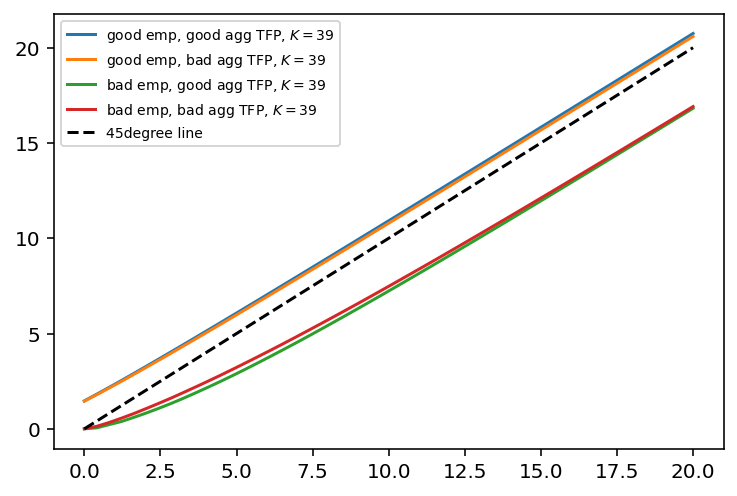

In [12]:
# Lets plot the policy functions!
plt.plot(agrid, np.maximum(g[1][1][4](agrid),phi),
         label=r'good emp, good agg TFP, $K=$'+str(round(Kgrid[4])))
plt.plot(agrid, np.maximum(g[1][0][4](agrid),phi),
         label=r'good emp, bad agg TFP, $K=$'+str(round(Kgrid[4])))
plt.plot(agrid, np.maximum(g[0][1][4](agrid),phi),
         label=r'bad emp, good agg TFP, $K=$'+str(round(Kgrid[4])))
plt.plot(agrid, np.maximum(g[0][0][4](agrid),phi),
         label=r'bad emp, bad agg TFP, $K=$'+str(round(Kgrid[4])))
plt.plot(agrid, agrid, 'k--',
         label=r'45degree line')
#plt.plot(agrid, np.maximum(g[0][0][9](agrid),phi),
#         label=r'bad emp, bad agg TFP, $K=$'+str(round(Kgrid[9])))

plt.legend(fontsize = 7)
plt.show()

In [13]:
# Simulation
N_agents = 500
T = 500
ag_shock = np.zeros((T, 1))
id_shock = np.zeros((T, N_agents))
np.random.seed(0)

# ag_shock = np.zeros((T, 1))
# Transition probabilities between aggregate states
prob_ag = np.zeros((2, 2))
prob_ag[0, 0] = prob[0, 0]+prob[0, 1]
prob_ag[1, 0] = 1-prob_ag[0, 0] # bad state to good state
prob_ag[1, 1] = prob[2, 2]+prob[2, 3]
prob_ag[0, 1] = 1-prob_ag[1, 1]

P = prob/np.kron(prob_ag, np.ones((2, 2)))
# generate aggregate shocks
mc = qe.MarkovChain(prob_ag)
ag_shock = mc.simulate(ts_length=T, init=0)  # start from bad state
# generate idiosyncratic shocks for all agents in the first period
draw = np.random.uniform(size=N_agents)
id_shock[0, :] = draw>0.1 #set state to good if probability exceeds ur_b

# generate idiosyncratic shocks for all agents starting in second period
draw = np.random.uniform(size=(T-1, N_agents))
for t in range(1, T):
    # Fix idiosyncratic transition matrix conditional on aggregate state
    transition = P[2*ag_shock[t-1]: 2*ag_shock[t-1]+2, 2*ag_shock[t]: 2*ag_shock[t]+2]
    transition_prob = [transition[int(id_shock[t-1, i]), int(id_shock[t-1, i])] for i in range(N_agents)]
    check = transition_prob>draw[t-1, :] #sign whether to remain in current state
    id_shock[t, :] = id_shock[t-1, :]*check + (1-id_shock[t-1, :])*(1-check)


In [14]:
Ks =np.zeros(T)
Ks[0] = k_ss
a1s = np.zeros((N_agents, T))
a0s = k_ss*np.ones(N_agents)
a1s[:,0] = a0s.copy()
K = interp1d(Kgrid, Kgrid, kind='nearest', fill_value='extrapolate')
# compute K_t+1
for t in range(1,T):
    for i in range(N_agents):
        a1s[i, t] = g[int(id_shock[t-1,i])][ag_shock[t-1]][np.where(Kgrid == K(Ks[t-1]))[0][0]](a1s[i,t-1])
    K1 = sum(a1s[:,t])
    Ks[t] = K1/N_agents
# update coefficients

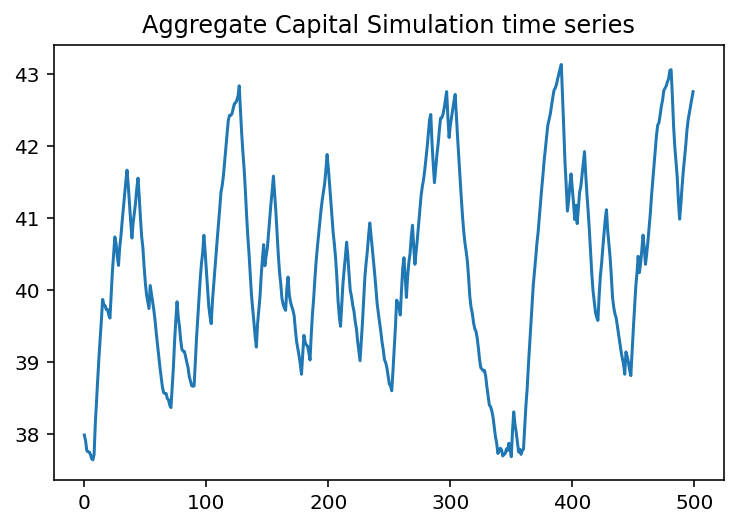

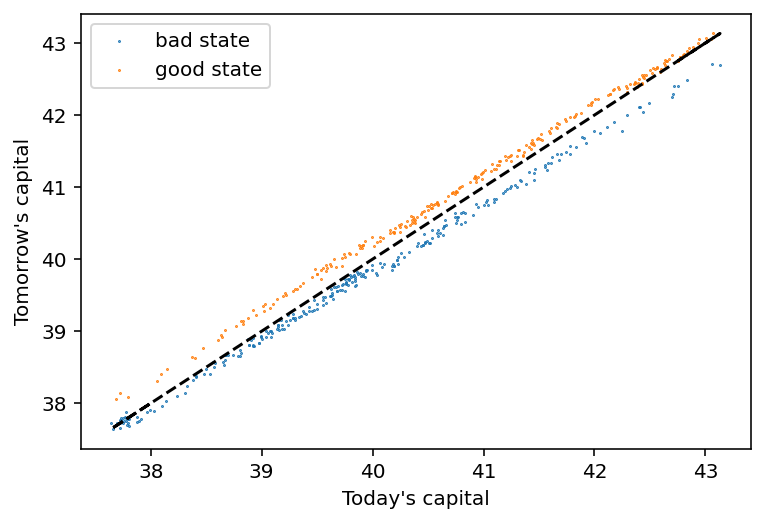

In [17]:
plt.plot(np.arange(0,T), Ks)
plt.title('Aggregate Capital Simulation time series')
plt.show()
index_b = np.where(ag_shock==0)
index1_b = np.array(index_b)+1
index_g = np.where(ag_shock==1)
index1_g = np.array(index_g)+1
index1_g[index1_g==500] = 499


plt.scatter(Ks[index_b], Ks[index1_b], marker='o', s=0.2, label = 'bad state')
plt.scatter(Ks[index_g], Ks[index1_g], marker='o', s=0.2, label = 'good state')
plt.plot(Ks, Ks, 'k--')
plt.legend()
plt.xlabel("Today's capital" )
plt.ylabel("Tomorrow's capital" )
plt.show()

In [18]:
# regress
import statsmodels.api as sm
# bad state
constant = np.ones((len(Ks[index_b]),1))
X = np.hstack((constant, Ks[index_b].reshape(len(Ks[index_b]),1)))
y = Ks[index1_b].reshape(len(Ks[index_b]),1)
reg = sm.OLS(y, X).fit()

# good state
constant = np.ones((len(Ks[index_g]),1))
X = np.hstack((constant, Ks[index_g].reshape(len(Ks[index_g]),1)))
y = Ks[index1_g].reshape(len(Ks[index_g]),1)
reg2 = sm.OLS(y, X).fit()

print(f'New alpha_b is {reg.params[0]}, and new beta_b is {reg.params[1]}')
print(f'New alpha_g is {reg2.params[0]}, and new beta_g is {reg2.params[1]}')

New alpha_b is 2.5290772907039507, and new beta_b is 0.9327353797360792
New alpha_g is 2.4605919348041354, and new beta_g is 0.9444361292075212


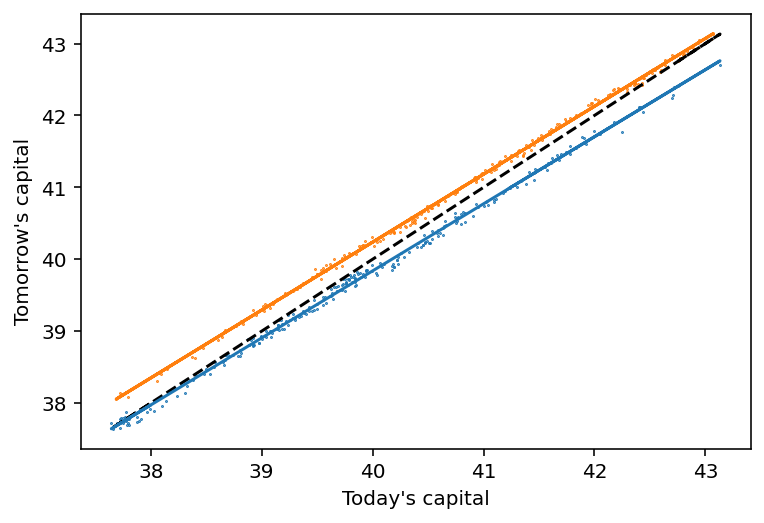

In [477]:
plt.scatter(Ks[index_b], Ks[index1_b], marker='o', s=0.2, label = 'bad state')
plt.scatter(Ks[index_g], Ks[index1_g], marker='o', s=0.2, label = 'bad state')
plt.plot(Ks, Ks, 'k--')
plt.plot(Ks[index_b], reg.params[0]+reg.params[1]*Ks[index_b])
plt.plot(Ks[index_g], reg2.params[0]+reg2.params[1]*Ks[index_g])
plt.xlabel("Today's capital" )
plt.ylabel("Tomorrow's capital" )
plt.show()

#### Full Efficient Code by Mario Silva


In [467]:
# Define Primitives of the KS 98 model
# Saving options
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)


def gen_params():
    beta = 0.99  # discount factor
    gamma = 1  # utility function parameter
    alpha = 0.36  # share of capital in production function
    delta = 0.025  # depreciation rate
    mu = 0.15  # unemployment benefits as a share of the wage
    l_bar = 1/0.9  # time endowment; normalizes labor supply to 1 in bad state
    k_ss = ((1/beta-(1-delta))/alpha)**(1/(alpha-1))
    return alpha, beta, gamma, delta, mu, l_bar, k_ss


def gen_grid():
    N = 10000  # number of agents for stochastic simulation
    J = 1000  # number of grid points for stochastic simulation
    k_min = 0
    k_max = 1000
    burn_in = 100
    T = 1000 + burn_in
    ngridk = 100
    x = np.linspace(0, 0.5, ngridk)
    tau = 7
    y = (x/np.max(x))**tau
    km_min = 30
    km_max = 50
    k = k_min + (k_max-k_min)*y
    ngridkm = 4
    km = np.linspace(km_min, km_max, ngridkm)
    return (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km,
            ngridk, ngridkm)


def shocks_parameters():
    nstates_id = 2    # number of states for the idiosyncratic shock
    nstates_ag = 2    # number of states for the aggregate shock
    ur_b = 0.1        # unemployment rate in a bad aggregate state
    er_b = (1-ur_b)   # employment rate in a bad aggregate state
    ur_g = 0.04       # unemployment rate in a good aggregate state
    er_g = (1-ur_g)   # employment rate in a good aggregate state
    epsilon = np.arange(0, nstates_id)
    delta_a = 0.01
    a = np.array((1-delta_a, 1+delta_a))
    prob = np.array(([0.525, 0.35, 0.03125, 0.09375],
                 [0.038889, 0.836111, 0.002083, 0.122917],
                 [0.09375, 0.03125, 0.291667, 0.583333],
                 [0.009115, 0.115885, 0.024306, 0.850694]))
    return nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob


def shocks():
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    ag_shock = np.zeros((T, 1))
    id_shock = np.zeros((T, N))
    np.random.seed(0)

    # ag_shock = np.zeros((T, 1))
    # Transition probabilities between aggregate states
    prob_ag = np.zeros((2, 2))
    prob_ag[0, 0] = prob[0, 0]+prob[0, 1]
    prob_ag[1, 0] = 1-prob_ag[0, 0] # bad state to good state
    prob_ag[1, 1] = prob[2, 2]+prob[2, 3]
    prob_ag[0, 1] = 1-prob_ag[1, 1]

    P = prob/np.kron(prob_ag, np.ones((2, 2)))
    # generate aggregate shocks
    mc = qe.MarkovChain(prob_ag)
    ag_shock = mc.simulate(ts_length=T, init=0)  # start from bad state
    # generate idiosyncratic shocks for all agents in the first period
    draw = np.random.uniform(size=N)
    id_shock[0, :] = draw>ur_b #set state to good if probability exceeds ur_b

    # generate idiosyncratic shocks for all agents starting in second period
    draw = np.random.uniform(size=(T-1, N))
    for t in range(1, T):
        # Fix idiosyncratic transition matrix conditional on aggregate state
        transition = P[2*ag_shock[t-1]: 2*ag_shock[t-1]+2, 2*ag_shock[t]: 2*ag_shock[t]+2]
        transition_prob = [transition[int(id_shock[t-1, i]), int(id_shock[t-1, i])] for i in range(N)]
        check = transition_prob>draw[t-1, :] #sign whether to remain in current state
        id_shock[t, :] = id_shock[t-1, :]*check + (1-id_shock[t-1, :])*(1-check)
    return id_shock, ag_shock

def convergence_parameters(nstates_ag=2):
    dif_B = 10**10 # difference between coefficients B of ALM on succ. iter.
    criter_k = 1e-8
    criter_B = 1e-6
    update_k = 0.77
    update_B = 0.3
    B = np.array((0,1))*np.ones((nstates_ag, 1))
    return B, dif_B, criter_k, criter_B, update_k, update_B

In [468]:
# Solve the individual problem

def individual(k_prime, B):
    dif_B, criter_k, criter_B, update_k, update_B = convergence_parameters()[1:]
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    alpha, beta, gamma, delta, mu, l_bar, k_ss = gen_params()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    e = np.array((er_b, er_g))
    u = 1-e
    replacement = np.array((mu, l_bar)) #replacement rate of wage
    #Tax rate depending on aggregate and idiosyncratic states

    #Transition probabilities by current state (k,km, Z, eps) and future (Z', eps')
    n = ngridk*ngridkm*nstates_ag*nstates_id
    P = np.zeros((ngridk, ngridkm, nstates_ag, nstates_id, nstates_ag*nstates_id))
    for z in range(nstates_ag*nstates_id):
        for i in range(nstates_ag):
            for j in range(nstates_id):
                P[:, :, i, j, z] = prob[2*i+j, z]*np.ones((ngridk, ngridkm))
    P = P.reshape((n, nstates_ag*nstates_id))

    k_indices = np.zeros(n)
    km_indices = np.zeros(n)
    ag = np.zeros(n)
    e_i = np.zeros(n)
    for s_i in range(n):
        k_indices[s_i], km_indices[s_i], ag[s_i], e_i[s_i] = np.unravel_index(s_i, (ngridk, ngridkm, nstates_ag, nstates_id))
    k_indices = np.asarray([int(x) for x in k_indices])
    km_indices = np.asarray([int(x) for x in km_indices])
    ag = np.asarray([int(x) for x in ag])
    e_i = np.asarray([int(x) for x in e_i])

    """
    Using indices, generate arrays for productivity, employment, aggregate
    capital, individual capital
    """

    Z = np.asarray([a[int(i)] for i in ag])
    L = np.asarray([e[int(i)] for i in ag])
    K = np.asarray([km[int(i)] for i in km_indices])
    k_i = np.asarray([k[int(i)] for i in k_indices])
    irate = alpha*Z*(K/(l_bar*L))**(alpha-1)
    wage = (1-alpha)*Z*(K/(l_bar*L))**alpha
    wealth = irate*k_i + (wage*e_i)*l_bar + mu*(wage*(1-e_i))+(1-delta)*k_i-mu*(wage*(1-L)/L)*e_i
    # Transition of capital depends on aggregate state
    K_prime = np.asarray([np.exp(B[ag[i], 0] + B[ag[i], 1]*np.log(K[i])) for i in range(n)])

    # restrict km_prime to fall into bounds
    K_prime = np.minimum(K_prime, km_max)
    K_prime = np.maximum(K_prime, km_min)

    # future interest rate and wage conditional on state (bad or good aggregate state)
    irate = np.zeros((n, nstates_ag))
    wage = np.zeros((n, nstates_ag))
    for i in range(nstates_ag):
        irate[:, i] = alpha*a[i]*((K_prime/(e[i]*l_bar))**(alpha-1))
        wage[:, i] = (1-alpha)*a[i]*((K_prime/(e[i]*l_bar))**alpha)

    # Tax rate
    tax = np.zeros((n, nstates_ag, nstates_id))
    for i in range(nstates_ag):
        for j in range(nstates_id):
            tax[:, i, j] = j*(mu*wage[:, i]*u[i]/(1-u[i]))
    # Solving the individual problem

    def iterate_policy(k_prime):
        dif_k = 1
        while dif_k > criter_k:
            """
             interpolate policy function k'=k(k, km) in new points (k', km')
            """
            k2_prime = np.zeros((n, nstates_ag, nstates_id))
            c_prime = np.zeros((n, nstates_ag, nstates_id))
            mu_prime = np.zeros((n, nstates_ag, nstates_id))
            #reshape k_prime for interpolation
            k_prime_reshape = k_prime.reshape((ngridk, ngridkm, nstates_id, nstates_ag))
            K_prime_reshape = K_prime.reshape((ngridk, ngridkm, nstates_id, nstates_ag))
            for i in range(nstates_ag):
                for j in range(nstates_id):
                    # capital in aggregate state i, idiosyncratic state j as a function of current states
                    k2_prime[:, i, j] = RectBivariateSpline(k, km, k_prime_reshape[:, :, i, j]).ev(k_prime_reshape, K_prime_reshape).reshape(n)
                    c_prime[:, i, j] = (irate[:, i]*k_prime + replacement[j]*(wage[:, i])
                    +(1-delta)*k_prime-k2_prime[:, i, j]-tax[:, i, j])
                    # replace negative consumption by very low positive number
            c_prime = np.maximum(c_prime, 10**(-10))
            mu_prime = c_prime**(-gamma)

            #Expectation term in Euler equation
            #Components in terms of all possible transitions
            expec_comp = np.zeros((n, nstates_ag, nstates_id))
            for i in range(nstates_ag):
                for j in range(nstates_id):
                    expec_comp[:, i, j] = (mu_prime[:, i, j]*(1-delta + irate[:, i]))*P[:, 2*i+j]
            """
            Expectation term in the Euler equation
             sum over various transitions (which have already been scaled by their probability)
            """
            expec = sum(expec_comp[:, i, j] for i in range(nstates_ag) for j in range(nstates_id))
            # current consumption from Euler equation if borrowing constraint is not binding
            cn = (beta*expec)**(-1/gamma)
            k_prime_n = wealth-cn
            k_prime_n = np.minimum(k_prime_n, k_max)
            k_prime_n = np.maximum(k_prime_n, k_min)
            """
            difference between new and previous capital functions
            """
            dif_k = np.linalg.norm(k_prime_n-k_prime)
            k_prime = update_k*k_prime_n + (1-update_k)*k_prime  # update k_prime_n
        c = wealth - k_prime
        return k_prime, c
    return iterate_policy(k_prime)

In [469]:
# Compute aggregate state
def aggregate_st(k_cross, k_prime, id_shock, ag_shock):
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
     ngridkm) = gen_grid()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    km_series = np.zeros((T,1))
    for t in range(T):
        """
        find t-th obs. by computing mean of t-th period cross sectional
        distribution of capital
        """
        km_series[t] = np.mean(k_cross)
        km_series[t] = np.minimum(km_series[t], km_max)
        km_series[t] = np.maximum(km_series[t], km_min)
        """
        To find km_series[t+1], we should compute a new cross sectional distribution
        at t+1.
        1) Find k_prime by interpolation for realized km_series[t] and agg. shock
        2) Compute new kcross by interpolation given previous kcross and id.shock
        """
        # Stack sampling points for interpolation as len(k)*len(epsilon) x 4
        # arr stores the coordinates of the sampling points: k rows, 4 columns
        interp_points = np.array(np.meshgrid(k, km_series[t], ag_shock[t], epsilon))
        interp_points = np.rollaxis(interp_points, 0, 5)
        interp_points = interp_points.reshape((len(k)*len(epsilon), 4))

        k_prime_t4 = interpn(points=(k, km, epsilon, epsilon), values=k_prime.reshape(ngridk, ngridkm, nstates_ag, nstates_id),
                             xi=interp_points).reshape(ngridk, nstates_id)
        # 4-dimensional capital function at time t is obtained by fixing known
        # km_series[t] and ag_shock
        interp_points = np.vstack((k_cross, id_shock[t,:])).T
        """
        given k_cross and idiosyncratic shocks, compute k_cross_n
        """
        k_cross_n = interpn(points=(k, epsilon), values= k_prime_t4.reshape(ngridk, nstates_id),
                            xi= interp_points)
        # restrict k_cross to be within [k_min, k_max]
        k_cross_n = np.minimum(k_cross_n, k_max)
        k_cross_n = np.maximum(k_cross_n, k_min)
        k_cross = k_cross_n
    return km_series, k_cross

In [470]:
# SOLVE IT!
def solve_ALM():
    # generate shocks, grid, parameters, and convergence parameters
    id_shock, ag_shock = shocks()
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    alpha, beta, gamma, delta, mu, l_bar, k_ss = gen_params()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    B, dif_B, criter_k, criter_B, update_k, update_B = convergence_parameters()

    k_prime = 0.9*k
    n = ngridk*ngridkm*nstates_ag*nstates_id
    k_prime = k_prime.reshape((len(k_prime), 1, 1, 1))
    k_prime = np.ones((ngridk, ngridkm, nstates_ag, nstates_id))*k_prime
    k_prime = k_prime.reshape(n)
    k_cross = np.repeat(k_ss, N)

    """
    Main loop
    Solve for HH problem given ALM
    Generate time series km_ts given policy function
    Run regression and update ALM
    Iterate until convergence
    """
    iteration = 0
    while dif_B > criter_B:
        # Solve for HH policy functions at a given law of motion
        k_prime, c = individual(k_prime, B)
        # Generate time series and cross section of capital
        km_ts, k_cross_1 = aggregate_st(k_cross, k_prime, id_shock, ag_shock)
        """
        run regression: log(km') = B[j,1]+B[j,2]log(km) for aggregate state
        """
        x = np.log(km_ts[burn_in:(T-1)]).flatten()
        X = pd.DataFrame([np.ones(len(x)), ag_shock[burn_in:(T-1)], x, ag_shock[burn_in:(T-1)]*x]).T
        y = np.log(km_ts[(burn_in+1):]).flatten()
        reg = sm.OLS(y, X).fit()
        B_new = reg.params
        B_mat = np.array((B_new[0], B_new[2], B_new[0]+B_new[1], B_new[2]+B_new[3])).reshape((2, 2))
        dif_B = np.linalg.norm(B_mat-B)
        print(dif_B)

        """
        To ensure that the initial capital distribution comes from the ergodic set,
        we use the terminal distribution of the current iteration as the initial distribution for
        subsequent iterations.

        When the solution is sufficiently accurate, we stop the updating and hold the distribution
        k_cross fixed for the remaining iterations
        """
        if dif_B > (criter_B*100):
            k_cross = k_cross_1 #replace cross-sectional capital distribution

        B = B_mat*update_B + B*(1-update_B) #update the vector of ALM coefficients
        iteration += 1
    return B, km_ts, k_cross, k_prime, c, id_shock, ag_shock

In [471]:
from time import time
start = time()
B, km_ts, k_cross, k_prime, c, id_shock, ag_shock = solve_ALM()
end = time()
print(end - start)

0.6730115911878533
0.02724534718494877
0.006215945303036624
0.0036783181118353863
0.0017676568071266058
0.0010982009191572088
0.0007929428690143512
0.0005844184583520681
0.0004397497706551115
0.0003323296250103941
0.00025326430311004277
0.00019448302525166742
0.00015058140444134673
0.00011746259187512956
9.22776654435168e-05
4.4982959370631356e-05
2.376181383622559e-05
1.3117568119107612e-05
7.648723972699143e-06
4.723516206999035e-06
3.0612849731669754e-06
2.050977197681122e-06
1.4011347819041618e-06
9.668466139519448e-07
124.16701412200928


In [472]:
# Figure comparing implied law of motion for aggregate capital stock and
# actual law of motion


def accuracy_figure(km_ts, ag_shock):
    T = len(km_ts)
    km_alm = np.zeros((T))
    km_alm[0] = km_ts[0]
    for i in range(0, T-1):
        km_alm[i+1] = np.exp(B[ag_shock[i], 0] + B[ag_shock[i], 1]*np.log(km_alm[i]))

    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(km_ts, label='Implied by policy rule')
    ax.plot(km_alm, label='Aggregate law of motion')
    ax.set_xlabel('Time')
    ax.set_ylabel('Aggregate capital stock')
    ax.legend(loc='best')
    plt.show()


#Capital accumulation policy function

def plot_policy(k_prime, km_ts):
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km,
            ngridk, ngridkm) = gen_grid()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    k_prime = k_prime.reshape((ngridk, ngridkm, nstates_ag, nstates_id))
    nstates_id, nstates_ag = shocks_parameters()[0:2]
    percentiles = [0.1, 0.25, 0.75, 0.9]
    km_percentiles = np.percentile(km_ts, percentiles)
    km_cycler = cycle(km_percentiles)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    for a in range(len(km_percentiles)):
        m, n = np.unravel_index(a, (2, 2))
        for i in range(nstates_ag):
            for j in range(nstates_id):
                ax[m, n].plot(k[0: 40], RectBivariateSpline(k, km, k_prime[:, :, i, j]).ev(k[0:40],
                        next(km_cycler)), label='Aggregate state = %s, Employment = %s' % (i,j))
                ax[m, n].set_xlabel('Capital accumulation: percentile = %s' % (percentiles[a]))
                ax[m, n].legend(loc='best', fontsize=8)
    plt.show()

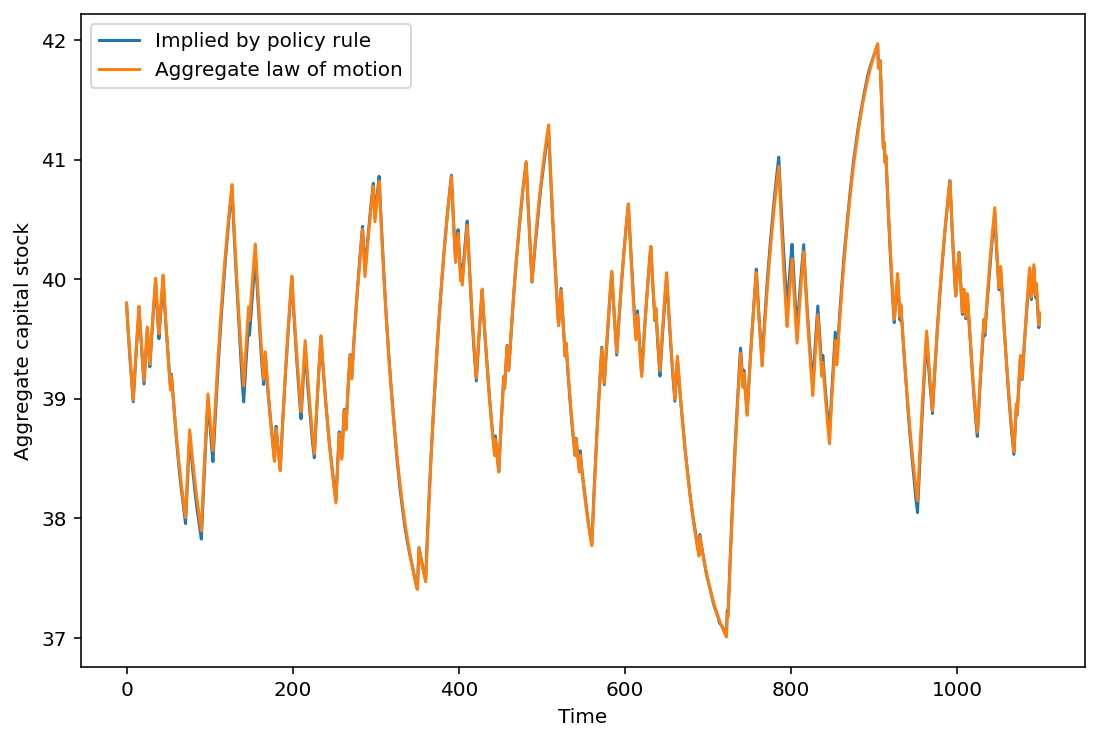

In [473]:
%config InlineBackend.figure_format = 'retina'
accuracy_figure(km_ts, ag_shock)

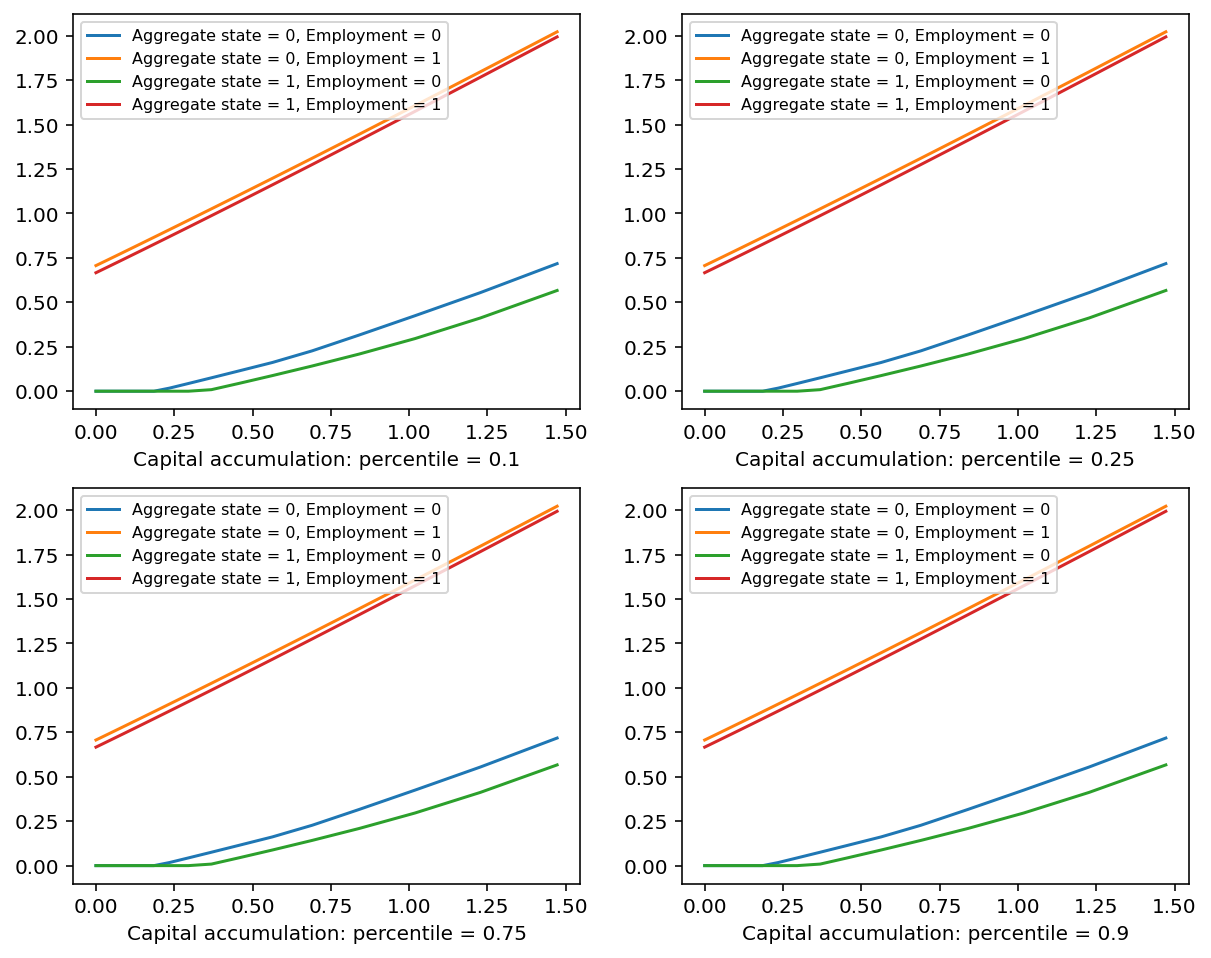

In [474]:
plot_policy(k_prime, km_ts)

Lets do it one iteration at a time to gain intuition on whats going on.

In [475]:
def solve_ALM_1():
    # generate shocks, grid, parameters, and convergence parameters
    id_shock, ag_shock = shocks()
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    alpha, beta, gamma, delta, mu, l_bar, k_ss = gen_params()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    B, dif_B, criter_k, criter_B, update_k, update_B = convergence_parameters()

    k_prime = 0.9*k
    n = ngridk*ngridkm*nstates_ag*nstates_id
    k_prime = k_prime.reshape((len(k_prime), 1, 1, 1))
    k_prime = np.ones((ngridk, ngridkm, nstates_ag, nstates_id))*k_prime
    k_prime = k_prime.reshape(n)
    k_cross = np.repeat(k_ss, N)

    """
    Main loop
    Solve for HH problem given ALM
    Generate time series km_ts given policy function
    Run regression and update ALM
    Iterate until convergence
    """
    iteration = 0
    #while dif_B > criter_B:
    # Solve for HH policy functions at a given law of motion
    k_prime, c = individual(k_prime, B)
    # Generate time series and cross section of capital
    km_ts, k_cross_1 = aggregate_st(k_cross, k_prime, id_shock, ag_shock)
    """
    run regression: log(km') = B[j,1]+B[j,2]log(km) for aggregate state
    """
    x = np.log(km_ts[burn_in:(T-1)]).flatten()
    X = pd.DataFrame([np.ones(len(x)), ag_shock[burn_in:(T-1)], x, ag_shock[burn_in:(T-1)]*x]).T
    y = np.log(km_ts[(burn_in+1):]).flatten()
    reg = sm.OLS(y, X).fit()
    B_new = reg.params
    B_mat = np.array((B_new[0], B_new[2], B_new[0]+B_new[1], B_new[2]+B_new[3])).reshape((2, 2))
    dif_B = np.linalg.norm(B_mat-B)
    print(dif_B)

    """
    To ensure that the initial capital distribution comes from the ergodic set,
    we use the terminal distribution of the current iteration as the initial distribution for
    subsequent iterations.

    When the solution is sufficiently accurate, we stop the updating and hold the distribution
    k_cross fixed for the remaining iterations
    """
    if dif_B > (criter_B*100):
        k_cross = k_cross_1 #replace cross-sectional capital distribution

    B = B_mat*update_B + B*(1-update_B) #update the vector of ALM coefficients
    iteration += 1
    return B, km_ts, k_cross, k_prime, c, id_shock, ag_shock

In [476]:
B, km_ts, k_cross, k_prime, c, id_shock, ag_shock = solve_ALM_1()
print(B)

0.6730115911878533
[[0.1345 0.9632]
 [0.141  0.962 ]]


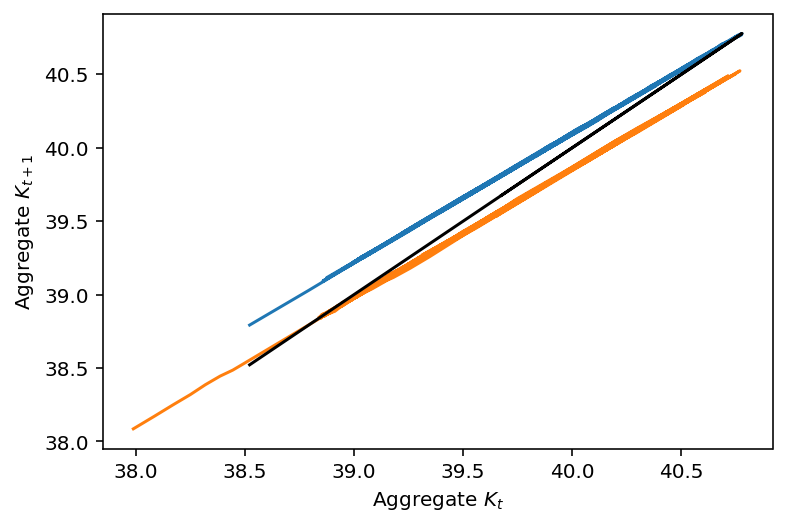

In [12]:
# Agg Today
km_t = np.delete(km_ts, -1, 0)
km_t1 = np.delete(km_ts, 0, 0)
ag_shock = np.delete(ag_shock, -1, 0)

# Agg good today
igood = np.where(ag_shock==1)[0]
# Agg bad today
ibad = np.where(ag_shock==0)[0]

plt.plot(km_t[igood], km_t1[igood])
plt.plot(km_t[ibad], km_t1[ibad])
plt.plot(km_t[igood], km_t[igood], color = 'k')
plt.xlabel(r'Aggregate $K_t$')
plt.ylabel(r'Aggregate $K_{t+1}$')
plt.show()

In [478]:
def solve_ALM_1(B1):
    # generate shocks, grid, parameters, and convergence parameters
    id_shock, ag_shock = shocks()
    (N, J, k_min, k_max, T, burn_in, k, km_min, km_max,  km, ngridk,
        ngridkm) = gen_grid()
    alpha, beta, gamma, delta, mu, l_bar, k_ss = gen_params()
    nstates_id, nstates_ag, epsilon, ur_b, er_b, ur_g, er_g, a, prob = shocks_parameters()
    B, dif_B, criter_k, criter_B, update_k, update_B = convergence_parameters()
    B = B1
    k_prime = 0.9*k
    n = ngridk*ngridkm*nstates_ag*nstates_id
    k_prime = k_prime.reshape((len(k_prime), 1, 1, 1))
    k_prime = np.ones((ngridk, ngridkm, nstates_ag, nstates_id))*k_prime
    k_prime = k_prime.reshape(n)
    k_cross = np.repeat(k_ss, N)

    """
    Main loop
    Solve for HH problem given ALM
    Generate time series km_ts given policy function
    Run regression and update ALM
    Iterate until convergence
    """
    iteration = 0
    #while dif_B > criter_B:
    # Solve for HH policy functions at a given law of motion
    k_prime, c = individual(k_prime, B)
    # Generate time series and cross section of capital
    km_ts, k_cross_1 = aggregate_st(k_cross, k_prime, id_shock, ag_shock)
    """
    run regression: log(km') = B[j,1]+B[j,2]log(km) for aggregate state
    """
    x = np.log(km_ts[burn_in:(T-1)]).flatten()
    X = pd.DataFrame([np.ones(len(x)), ag_shock[burn_in:(T-1)], x, ag_shock[burn_in:(T-1)]*x]).T
    y = np.log(km_ts[(burn_in+1):]).flatten()
    reg = sm.OLS(y, X).fit()
    B_new = reg.params
    B_mat = np.array((B_new[0], B_new[2], B_new[0]+B_new[1], B_new[2]+B_new[3])).reshape((2, 2))
    dif_B = np.linalg.norm(B_mat-B)
    print(dif_B)

    """
    To ensure that the initial capital distribution comes from the ergodic set,
    we use the terminal distribution of the current iteration as the initial distribution for
    subsequent iterations.

    When the solution is sufficiently accurate, we stop the updating and hold the distribution
    k_cross fixed for the remaining iterations
    """
    if dif_B > (criter_B*100):
        k_cross = k_cross_1 #replace cross-sectional capital distribution

    B = B_mat*update_B + B*(1-update_B) #update the vector of ALM coefficients
    iteration += 1
    return B, km_ts, k_cross, k_prime, c, id_shock, ag_shock

In [479]:
B, km_ts, k_cross, k_prime, c, id_shock, ag_shock = solve_ALM_1(B)
print(B)

0.028183804558440533
[[0.1279 0.9648]
 [0.1362 0.9633]]


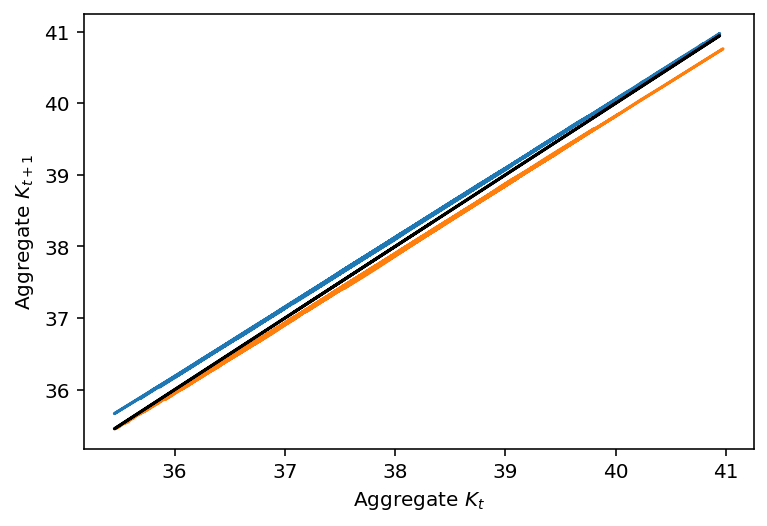

In [480]:
# Agg Today
km_t = np.delete(km_ts, -1, 0)
km_t1 = np.delete(km_ts, 0, 0)
ag_shock = np.delete(ag_shock, -1, 0)

# Agg good today
igood = np.where(ag_shock==1)[0]
# Agg bad today
ibad = np.where(ag_shock==0)[0]

plt.plot(km_t[igood], km_t1[igood])
plt.plot(km_t[ibad], km_t1[ibad])
plt.plot(km_t[igood], km_t[igood], color = 'k')
plt.xlabel(r'Aggregate $K_t$')
plt.ylabel(r'Aggregate $K_{t+1}$')
plt.show()

In [481]:
B, km_ts, k_cross, k_prime, c, id_shock, ag_shock = solve_ALM_1(B)
print(B)

0.013304878423843846
[[0.1242 0.9657]
 [0.135  0.9638]]


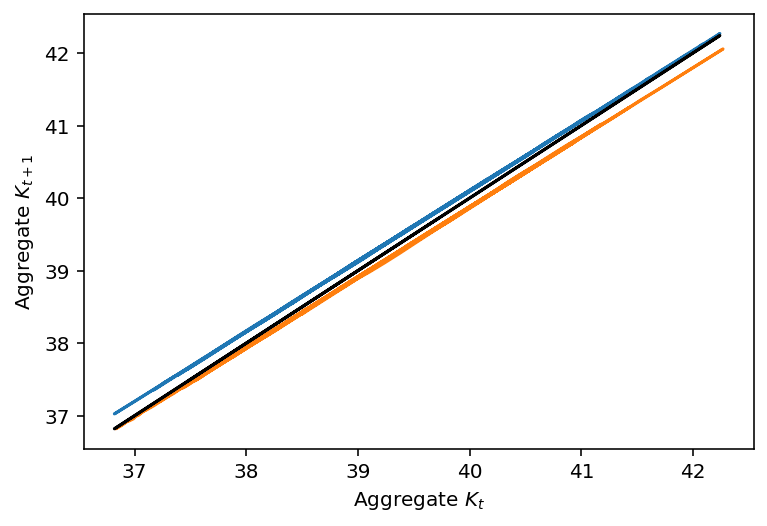

In [482]:
# Agg Today
km_t = np.delete(km_ts, -1, 0)
km_t1 = np.delete(km_ts, 0, 0)
ag_shock = np.delete(ag_shock, -1, 0)

# Agg good today
igood = np.where(ag_shock==1)[0]
# Agg bad today
ibad = np.where(ag_shock==0)[0]

plt.plot(km_t[igood], km_t1[igood])
plt.plot(km_t[ibad], km_t1[ibad])
plt.plot(km_t[igood], km_t[igood], color = 'k')
plt.xlabel(r'Aggregate $K_t$')
plt.ylabel(r'Aggregate $K_{t+1}$')
plt.show()